In [18]:
# package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# loaded data into a dataframe

df = pd.read_csv("./lending_club_2020_train.csv", low_memory=False)

# 결측치가 50%이상인 칼럼 제거
df = df.loc[:, (df.isnull().mean() < 0.5) | (df.columns == "loan_status")]

# 필요 없는 칼럼 삭제
df = df.drop(columns=["id",
                      "url",
                      "title",
                      "application_type",
                      "policy_code",
                      "hardship_flag",
                      "verification_status",
                      "pymnt_plan",
                      "initial_list_status",
                      "recoveries",
                      "collection_recovery_fee",
                      "collections_12_mths_ex_med",
                      "num_tl_120dpd_2m",
                      "debt_settlement_flag"
                      ])

# id, url, title, application_type, policy_code, hardship_flag는 사용하기 어려운 데이터
# verification_status는 유의미할 거 같지만 없어도 크게 상관 없을거같음
# pymnt_plan는 모든 데이터가 다 똑같음
# collections_12_mths_ex_med 의료 빼고 채권추심. 삭제
# num_tl_120dpd_2m 업데이트가 안되었을 가능성 존재. 삭제
# debt_settlement_flag 데이터 불균형이 심함. 삭제


In [66]:
# 시계열 데이터는 일단 제외하고 작업

# inq_last_~~ 는 대출 실행 전 데이터임
# out_prncp~~ 는 대출이 실행된 시점부터 마지막 상태 처리 되기 전까지 충분히 열람할 수 있는 데이터

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755295 entries, 0 to 1755294
Data columns (total 92 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float64
 1   funded_amnt                 float64
 2   funded_amnt_inv             float64
 3   term                        object 
 4   int_rate                    object 
 5   installment                 float64
 6   grade                       object 
 7   sub_grade                   object 
 8   emp_title                   object 
 9   emp_length                  object 
 10  home_ownership              object 
 11  annual_inc                  float64
 12  issue_d                     object 
 13  loan_status                 object 
 14  purpose                     object 
 15  zip_code                    object 
 16  addr_state                  object 
 17  dti                         float64
 18  delinq_2yrs                 float64
 19  earliest_cr_line     

### EDA MEMO
+ p2p 대출은 LC에 차입자 정보가 넘어오면, 해당 차입자에 대해서 투자자가 모집되어야만 차입자에 돈을 줄 수 있음. 왜냐하면 LC는 중개기관의 역할만 하기 때문.
+ 특히 이 때문에 발생하는 문제로, 우리가 loan_status를 만드는 목적은 차입자를 좋은 상품으로 포장해 투자자에게 연결시켜주기 전에 loan_status를 예측해서 잠재적 부도율을 구하고 sharp ratio를 최적화하는 것이 목표인데, total_rec_late_fee(지금까지 받은 총 연체료)같은 데이터는 투자가 이미 이루어진 후에 발생하는 데이터이기 때문에 사용할 수 없는 데이터가 되어버림.
+ 이 점을 해소하기 위해서 여러 차입자를 묶어 ABS, CDO처럼 자산을 상품화, 유동화 시키면, 투자자에게 먼저 투자금을 유치한 후 기존 차입자와 신규 차입자를 한 상품에 넣고 상품의 sharp ratio를 측정할 수 있다. 따라서 이렇게 로직을 설정할 경우 total_pymnt, total_rec_int같은 지표를 사용할 당위성을 갖추게 됌.

In [68]:
# EDA
# 결측치가 많은 순서대로 내림차순 해보니 29.6%의 결측치를 가지는 칼럼을 마지막으로 결측치가 12.6% 이하로 확 줄었음.
# 데이터 개수가 100만건 이상이기 때문에, 약 30%의 결측치만 가져도 절대적으로 매우 많은 결측값을 가지게 됌.
df["loan_status"].value_counts()

loan_status
Fully Paid                                             898522
Current                                                618688
Charged Off                                            217366
Late (31-120 days)                                       9840
In Grace Period                                          6049
Late (16-30 days)                                        1620
Issued                                                   1258
Does not meet the credit policy. Status:Fully Paid       1223
Does not meet the credit policy. Status:Charged Off       460
Default                                                   268
Name: count, dtype: int64

In [5]:
# 타겟변수로 쓸 loan_status의 값을 기준으로 데이터 정리
# 'Fully Paid', 'Current', 'Charged Off' 값만 남기고 나머지 행 삭제
df = df[df['loan_status'].isin(['Fully Paid', 'Current', 'Charged Off'])]
df["loan_status"].value_counts()


loan_status
Fully Paid     898522
Current        618688
Charged Off    217366
Name: count, dtype: int64

In [6]:
# 결측치가 있는 칼럼 검색
missing_columns = df.columns[df.isnull().any()].tolist()
print(len(missing_columns))

56


In [7]:
# 각 컬럼의 결측치 개수 계산
missing_counts = df.isnull().sum()

# 결측치가 있는 컬럼만 선택
missing_counts = missing_counts[missing_counts > 0]

# 결측치 비율 계산 (전체 행 수에 대한 비율)
missing_ratios = missing_counts / len(df)

# 결측치 개수와 비율을 하나의 DataFrame으로 생성한 후, 내림차순 정렬
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Ratio': missing_ratios
}).sort_values(by='Missing Count', ascending=False)

missing_df

# 결측치 개수를 내림차순으로 확인 결과 29.84%의 결측치를 가지는 total_cu_tl 다음 가장 많은 결측치가 12.63%로 확 줄어듬.
# 29.84%의 결측치는 절대적인 결측치 개수로 봤을 때 52만개에 달함, 

,Missing Count,Missing Ratio
il_util,689533,0.397523
mths_since_rcnt_il,553159,0.318902
all_util,517823,0.298530
open_act_il,517606,0.298405
open_acc_6m,517606,0.298405
total_bal_il,517606,0.298405
open_il_12m,517606,0.298405
open_il_24m,517606,0.298405
open_rv_12m,517606,0.298405
open_rv_24m,517606,0.298405


### EDA MEMO
+ 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'
+ 결측치가 29.84%이상, 52만개 이상인 칼럼들. 칼럼을 드랍하고 결측치를 보강한다음 Feature Selection을 진행한다. 추후 다시 포함시킬지 고민.

In [8]:
# 결측치 비율 계산 및 29% 이상인 컬럼 리스트 생성
threshold = 0.29
missing_ratio = df.isnull().mean()       # 각 컬럼의 결측치 비율 계산
cols_with_missing = missing_ratio[missing_ratio >= threshold].index.tolist()  # 29% 이상인 컬럼 선택

df = df.drop(columns=cols_with_missing)
df.to_csv("./Data_v1.csv", index=False)


### EDA MEMO
+ Object 타입 데이터 빼고 수치형 데이터 먼저 결측치 처리

In [33]:
# 수치형 데이터
# 데이터 로드
df = pd.read_csv("./Data_v1.csv")

# 수치형 데이터(숫자형 컬럼)만 선택
df_numeric = df.select_dtypes(include=['number'])

# 각 수치형 컬럼의 결측치 개수 계산
missing_counts = df_numeric.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

# 결측치 비율 계산 (전체 행 수에 대한 비율)
missing_ratios = missing_counts / len(df)

# 결측치 개수와 비율을 하나의 DataFrame으로 생성한 후, 결측치 개수를 기준으로 내림차순 정렬
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Ratio': missing_ratios
}).sort_values(by='Missing Count', ascending=False)

missing_df



,Missing Count,Missing Ratio
mths_since_recent_inq,219162,0.126349
mo_sin_old_il_acct,90825,0.052361
bc_util,48437,0.027924
percent_bc_gt_75,47886,0.027607
bc_open_to_buy,47592,0.027437
mths_since_recent_bc,46440,0.026773
pct_tl_nvr_dlq,40505,0.023352
avg_cur_bal,40471,0.023332
mo_sin_rcnt_rev_tl_op,40405,0.023294
mo_sin_old_rev_tl_op,40405,0.023294


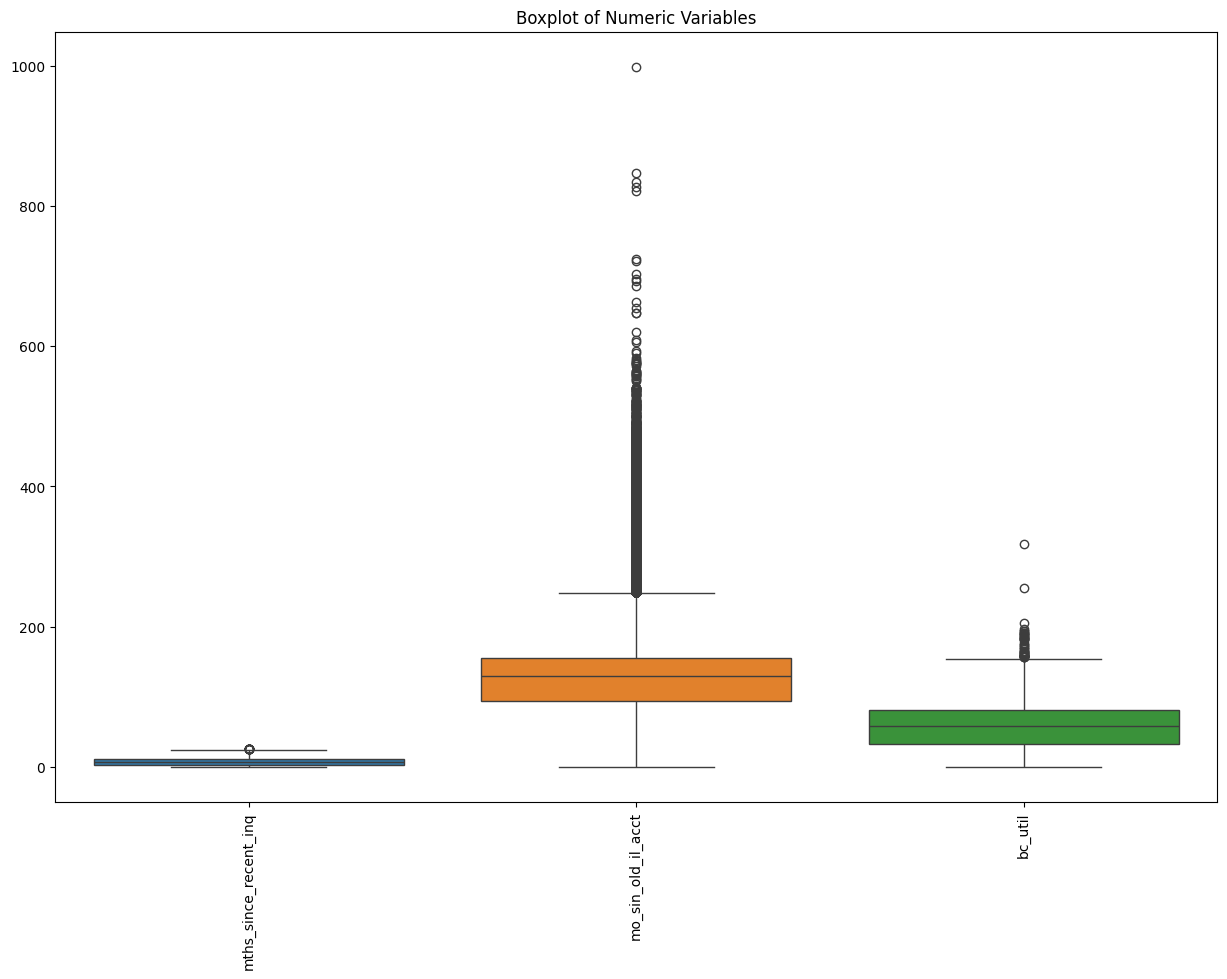

In [29]:
# 예시: 데이터프레임 df에서 수치형 컬럼만 선택
numeric_cols = df[["mths_since_recent_inq", "mo_sin_old_il_acct", "bc_util"]]

# 박스플롯 그리기
plt.figure(figsize=(15, 10))
sns.boxplot(data=numeric_cols)
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Variables")
plt.show()


In [34]:
# 범주형 데이터
# 데이터 로드
df = pd.read_csv("./Data_v1.csv")

# 수치형 데이터(숫자형 컬럼)만 선택
df_categorical = df.select_dtypes(include=['object'])

# 각 수치형 컬럼의 결측치 개수 계산
missing_counts = df_categorical.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

# 결측치 비율 계산 (전체 행 수에 대한 비율)
missing_ratios = missing_counts / len(df)

# 결측치 개수와 비율을 하나의 DataFrame으로 생성한 후, 결측치 개수를 기준으로 내림차순 정렬
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Ratio': missing_ratios
}).sort_values(by='Missing Count', ascending=False)

missing_df


,Missing Count,Missing Ratio
emp_title,155392,0.089585
emp_length,121041,0.069781
last_pymnt_d,2034,0.001173
revol_util,1538,0.000887
last_credit_pull_d,41,0.000024


In [31]:
df["bc_util"]

0          20.6
1          35.4
2          70.4
3          16.1
4          77.0
           ... 
1734571    97.2
1734572     8.8
1734573    95.4
1734574    12.3
1734575    54.1
Name: bc_util, Length: 1734576, dtype: float64